In [1]:
import re
import pandas as pd
import numpy as np
from  datetime import datetime, timedelta
import math
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
sns.set_style("darkgrid")

In [3]:
def get_text(filepath: str):
    with open(filepath) as file:
        text = file.read()
        return text

In [4]:
def process_log_new_models(log, good_qty, bad_qty):
    """
    Args: 
    log - The log firing patterns to be processed
    good_qty - Number of Good sates on the Petri Net (This Method assumes a redundancy model)
    bad_qty - Number of Bad sates on the Petri Net (This Method assumes a redundancy model)
    """

    log_processed = pd.Series([], dtype='float64')
    log_processed = {}

    str_pattern = ""
    for i in range(good_qty):
        str_pattern += f"Good{i+1} = 1|"
    
    if bad_qty > 1:
        
        for i in range(bad_qty):
            str_pattern += f"Bad{i+1} =  1|"
        str_pattern[0:-2]
    else:
        str_pattern += "Bad = 1"


    for i in range(0, len(log)):
        try:
            if i < len(log) - 1:
                state = re.findall(str_pattern, log[i].split("Enabling state before action firing")[1])[0]
            else:
                state = re.findall(str_pattern, log[i].split("Affected state after firing")[1])[0]
            # print('state',state)
        except:
            pass
        if i > 0:
            time_idx = float((re.findall("\d+\.\d+|\d+\d+",log[i])[0]))
        else:
            time_idx = 0.0

        for i in range(good_qty):
            if (f"Good{i+1}") in state or 'Normal' in state:
                log_processed[time_idx] = f"Good{i+1}"
            elif (f"Bad") in state or 'Failure' in state:
                log_processed[time_idx] = f"Bad"
    return pd.Series(log_processed)

In [5]:
def gen_time_series_2023(log_processed, step_size):
    """
    Receives a set of firing event patterns and creates a time series
    Args: 
        log_processed: Array with the firing patterns 
        step_size: Time step f the simulation
    Returns
        The time series
    """
    time_series = pd.Series([], dtype='float64')
    index = 0
    for i in range(len(log_processed) - 1):
        # if i != 0:
        time_series.loc[float(log_processed.index[i])] = log_processed.iloc[i]
        # print(float(log_processed.index[i]))
        # print(f"Na iteração {i} ")
        
        if i  < len(log_processed) - 1:
            new_index = float(log_processed.index[i+1])
            number_of_values_to_add = int(np.floor((new_index - index)/step_size))    
            value = log_processed.iloc[i]

            idxs = np.array(range(number_of_values_to_add))*step_size + index
            
            if number_of_values_to_add < 0:
                 print(number_of_values_to_add)
            time_series = pd.concat([time_series, pd.Series(np.ones(number_of_values_to_add)*value , idxs)])
            index = new_index

    return time_series

In [6]:
def get_date_from_hours_passed(hours_passed, start_date):
    """
        Retrives the correct datetime given a number of hours passed and start_date
        Args:
            hours_passed: The number of passed hours
            start_date: The reference date
    """
    start_datetime = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
    end_datetime = start_datetime + timedelta(hours=hours_passed)
    return end_datetime

In [7]:
def concat_series(number_batches, batches,mapping:dict, specify_batch=False, good_qty = 2, bad_qty=1,  time_step: int = 1 ):
    """
        Builts a concatenated time series using a vector of batches from a Petri Net simulation of Redundancy Models. 
        It can be be used to create a time series specifying a batch index
        when passing the parameter specify_batch = True
        Returns:
            The concatenated time series
        Args:  
        number_batches - Number of batches to be used in the concatenation
        batches - Vector containing batches extracted from log file
        states_map: A dictionary containing the map from sates name to float 
        specify_batch - Parameter used to specify if only one batch should be used. 
            In case of True, it will the 'number_batches' param as the index to specify the required batch
        good_qty - Number of Good sates on the Petri Net (This Method assumes a redundancy model)
        bad_qty - Number of Bad sates on the Petri Net (This Method assumes a redundancy model)
        time_step - Time step of the simualtion. Default is 1 hour

    """
    time_step = 1 

    series = pd.Series([])
    if not specify_batch:
        for i in range(number_batches):
            log = batches[i+1].split("#### Firing")
            log_processed = process_log_new_models(log, good_qty, bad_qty)
            log_processed = log_processed.apply(lambda x: mapping[x])          
            unit_series = gen_time_series_2023(log_processed,time_step).reset_index(drop=True)
            series = pd.concat([series, unit_series])
    else:
        log = batches[number_batches].split("#### Firing")
        log_processed = process_log_new_models(log, good_qty, bad_qty)
        log_processed = log_processed.apply(lambda x: mapping[x])
        
        unit_series = gen_time_series_2023(log_processed,time_step).reset_index(drop=True)
        series = pd.concat([series, unit_series])

    series = series.reset_index(drop=True)
    series.index = series.index*time_step
    return series

### Scenario 1 - Chosing a batch index to built the time series from Mobius Log (mannualy)

#### The following steps are show to explain how to create the time series step by step

In [8]:
#Step 1 - Defining Maping for Petri Net states. In this example we are dealing with a petri net with 2 redundancy nodes and a Bad state

mapping_faults_exp = {
    'Good1' : 0,
    'Good2': 1, 
    'Bad' :2,
}

#Step 2 - Chose the batch index you want to use for builting the time series
idx = 1 


#Step 3 - Read log file
log_text = get_text("mobius_log.txt")

#Step 4 - Read batches from log file - Splitting the file

batches = log_text.split('##### NEW BATCH #####')

#Testing splittig on #Batch pattern
# print("Batch pattern\n", batches[idx])

#Step 5 - Splitig the log into firing events
log_firings = batches[idx].split("#### Firing")

#Step 6  Process the log file from the chosen batch
processed_log = process_log_new_models(log=log_firings, good_qty=2, bad_qty=1)

#Step 7 - Apply mappings to states 
processed_log = processed_log.apply(lambda x: mapping_faults_exp[x])


#Step 8 - Generate the time Series with the processed log
time_series = gen_time_series_2023(
    log_processed=processed_log,
    step_size=1, # The total time of simulation
)

print(f"Time Series from batch #{idx}:\n", time_series)


Time Series from batch #1:
 0.0        1.0
0.0        1.0
1.0        1.0
2.0        1.0
3.0        1.0
          ... 
80698.3    1.0
80699.3    1.0
80700.3    1.0
80701.3    1.0
80702.3    1.0
Length: 80715, dtype: float64


### Scenario 2 - Concatenate multiple batches to built one time series

#### You can use more than one batch appendded to built a unique timeseries

In [9]:
#Step 1 - Chose the number of batches to be used
number_batches = 3

#Step 2 - Call the funnction that summarizes the process shown in the first scenario
multiple_batches_time_series = concat_series(
    number_batches=number_batches,
    batches = batches,
    mapping=mapping_faults_exp,
    specify_batch=False, # In this case you do not have to specify the batch idx, so this param is set as False
    good_qty=2,
    bad_qty=1,
    time_step=1
)

print("Time series with 3 batches\n:", multiple_batches_time_series)

/tmp/ipykernel_32340/3789234148.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pd.Series([])


Time series with 3 batches
: 0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
241095    1.0
241096    1.0
241097    1.0
241098    1.0
241099    1.0
Length: 241100, dtype: float64


### Scenario 3 - Use a specific batch to built one time series (Using the concat_time_series function)

#### You can reproduce the Scenario #1 using the concat_series function. To do so, specify the desired batch index  using the param 'number_batches' and set the parameter "specify_batch" as True

In [10]:
#Step 1 - Set the number of batches param as the index number you want to use. For exammple, in this case we will use the index #3
idx = 3

#Step 2 - Call the funnction that summarizes the proccess shown in the first scenario, passing the index to the parameter number_batches
one_batches_time_series = concat_series(
    number_batches=idx,
    batches = batches,
    mapping=mapping_faults_exp,
    specify_batch=True, # In this case we set this param as True, so the alg will know that it needs to use number_bacthes as the index number,
    good_qty=2,
    bad_qty=1,
    time_step=1
)

print("Time series with One batch\n:", one_batches_time_series)

Time series with One batch
: 0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
75971    1.0
75972    1.0
75973    1.0
75974    1.0
75975    1.0
Length: 75976, dtype: float64


/tmp/ipykernel_32340/3789234148.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pd.Series([])


### Scenario #4 Creating time series using from Mobius Log using statistical approach

#### Since there are many batches in the log, you can choose one of the runs and create the time series from it.

A possible strategy for choosing the batch may be to choose the one with the number of events (Good, Good2 and Bad) that is statistically closest to all existing batches

Next, a function is defined to calculate the average count for each state in each batch. The function compares each batch's event count per state to the general average using the standard deviation definition.
In other words, the sum of the squared difference between the count of events for each state of each batch and the general average of all batches.


Having all the distances computed, the function chooses the series that is most statistically close to the set average, taking into account the sum of the distances of all states for each batch individually

In [11]:

def compute_time_series_index_by_statistical_strategy(
        number_batches: int,
        batches,
        states_map: dict,
        qty_good_states: int = 2,
        qty_bad_states: int = 2,
        specify_batch=False,
):

    """  
    Computes the best bacth index to be used to built the time series, using an statistical approach
    
    Args: 
    number_batches - Number of batches to be used in the concatenation
    batches - Vector containing batches extracted from log file
    states_map: A dictionary containing the map from sates name to float 
    specify_batch - Parameter used to specify if only one batch should be used. 
        In case of True, it will the 'number_batches' param as the index to specify the required batch
    good_qty - Number of Good sates on the Petri Net (This Method assumes a redundancy model)
    bad_qty - Number of Bad sates on the Petri Net (This Method assumes a redundancy model)
    """

    averages = {}
    distances = {}
    sum_dists = []

    for i in range(1, number_batches + 1):
        #In this case we are specifying the batch with for index, ad computing  the count for all states. 
        series = concat_series(number_batches = i,
                               batches= batches,
                               good_qty=qty_good_states,
                               bad_qty=qty_bad_states,
                               mapping=mapping_faults_exp,
                               specify_batch=True)
        
        for state_name, state_number in states_map.items():
            state_count = 100*series.value_counts(normalize=True).loc[float(state_number)]
            try:
                averages[state_name] +=  state_count
            except KeyError:
                averages[state_name] = state_count


    for state_name, state_count in averages.items():
        if specify_batch:
            number_batches = 1
        averages[state_name] +=  state_count/number_batches

    print(f"Averages per state, considering {number_batches} batches:\n", averages )

    #Next step choses the batch that is more closely to the stats
    for i in range(1, number_batches + 1):
        series = concat_series(
            number_batches= i,
            batches = batches,
            good_qty=qty_good_states, 
            bad_qty=qty_bad_states,
            mapping=states_map,
            specify_batch=True,
        )


        for state_name, state_number in states_map.items():
            state_count = 100*series.value_counts(normalize=True).loc[float(state_number)]
            try:
                distances[state_name] +=  (state_count - averages[state_name])**2
            except KeyError:
                distances[state_name] = (state_count - averages[state_name])**2

        for state_name, state_count in averages.items():
            if specify_batch:
                number_batches = 1
            distances[state_name] +=  state_count/number_batches

        dist = math.sqrt(sum(list(distances.values())))
        sum_dists.append(dist)
        chosen_idx = np.argmin(sum_dists) + 1
    print("Std dev per batches:\n", sum_dists)
    
    return chosen_idx

In [12]:
#Step 1 - Define the number of batches you want to use in the analysis
number_batches = 10


#Call the function passing gthe parameters. It will return the index of the batch that should be used 
#The other params will follow as the previous examples
serie_index  = compute_time_series_index_by_statistical_strategy(
    number_batches = number_batches,
    batches=batches,
    states_map=mapping_faults_exp,
    qty_good_states=2,
    qty_bad_states=1,
    specify_batch=False,
)

print("Index chosen", serie_index)

/tmp/ipykernel_32340/3789234148.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pd.Series([])


Averages per state, considering 10 batches:
 {'Good1': 467.732610712982, 'Good2': 585.6296648223527, 'Bad': 46.63772446466548}
Std dev per batches:
 [687.3661461128062, 970.3654879828664, 1187.0279891422342, 1368.7191916984495, 1527.8346571817087, 1672.1281792186282, 1806.3289737588864, 1932.9192025366133, 2049.996961497536, 2159.8252192744103]
Index chosen 1


In [13]:
#Step 2 - Use the chosen idex to crerate the time series
chosen_series = concat_series(number_batches=serie_index,
                              batches=batches,
                              good_qty=2,
                              bad_qty=1,
                              mapping=mapping_faults_exp,
                              specify_batch=True)


/tmp/ipykernel_32340/3789234148.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pd.Series([])


In [14]:
#Checking time series dist
100*chosen_series.value_counts(normalize=True)

1.0    50.906275
0.0    37.367280
2.0    11.726445
dtype: float64

Adding date index

As the date start itself it is not important, you can define any value for the initial date. The durantion though will reflect the simualtion duration. In this case, it is a 10 years simulation. In the notebook, we only did for this example, but it can be done for all of the produced titme series

In [15]:
start_date = "2019-01-01 0:0:0" 
final_series = chosen_series.copy()
final_series.index = [get_date_from_hours_passed(hours_passed, start_date) for hours_passed in chosen_series.index]
final_series

2019-01-01 00:00:00    1.0
2019-01-01 01:00:00    1.0
2019-01-01 02:00:00    1.0
2019-01-01 03:00:00    1.0
2019-01-01 04:00:00    1.0
                      ... 
2028-03-16 22:00:00    1.0
2028-03-16 23:00:00    1.0
2028-03-17 00:00:00    1.0
2028-03-17 01:00:00    1.0
2028-03-17 02:00:00    1.0
Length: 80715, dtype: float64

Creating dataframe for the time Series

In [16]:
df_time_series = pd.DataFrame(final_series, columns=['system_state'])
display(df_time_series)
df_time_series.to_parquet("series_example.parquet")

,system_state
2019-01-01 00:00:00,1.0
2019-01-01 01:00:00,1.0
2019-01-01 02:00:00,1.0
2019-01-01 03:00:00,1.0
2019-01-01 04:00:00,1.0
...,...
2028-03-16 22:00:00,1.0
2028-03-16 23:00:00,1.0
2028-03-17 00:00:00,1.0
2028-03-17 01:00:00,1.0


Plotting the series for better understanding

Text(0.5, 1.0, 'Fault time series signal obtained from PetriNet log file')

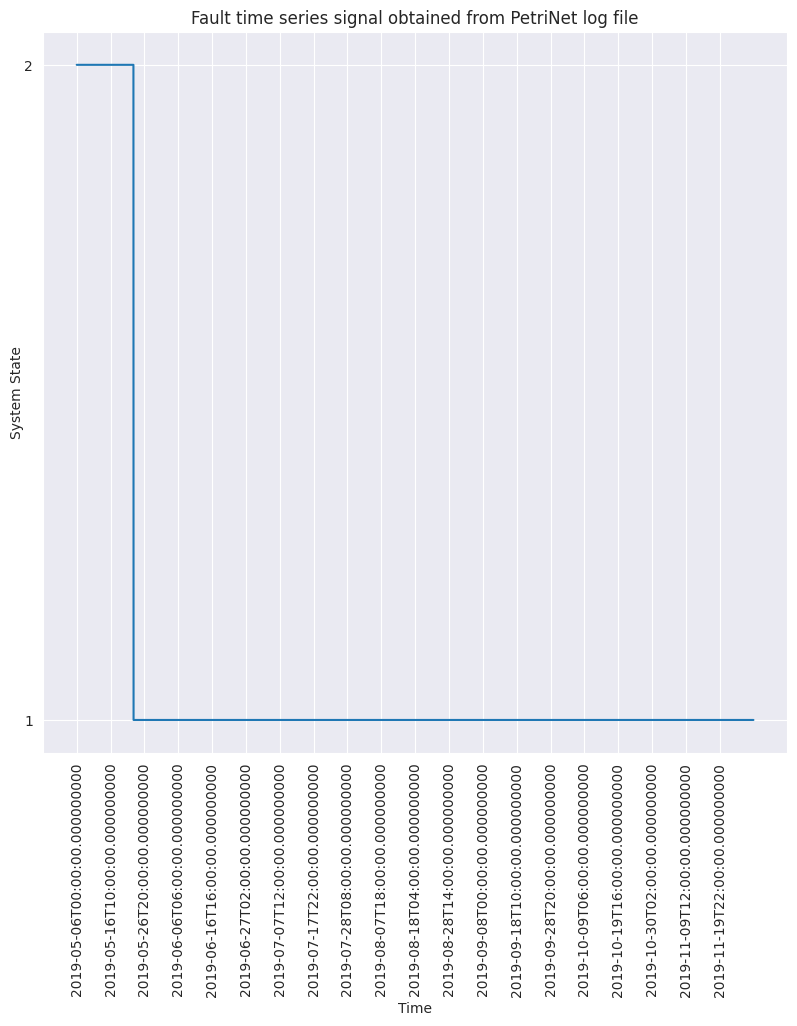

In [17]:
init = 3000
end = 8000
plt.figure(figsize=(8,10))
plt.xticks(labels=final_series.index.values[init:end], ticks=  range(end - init),rotation = 90,)
plt.yticks([0,1,2], labels=[0, 1, 2])
plt.tight_layout()
plt.locator_params(axis='x', nbins=20)
plt.ylabel("System State", labelpad=0.2)
plt.xlabel("Time")

# plt.xlim(series_model2.index[init], series_model2.index[end])
plt.plot(final_series.values[init:end])
plt.title("Fault time series signal obtained from PetriNet log file")